# A/B Test: Did moving the in-game gate from level 30 → level 40 change retention?
**Dataset:** Cookie Cats (columns: `userid`, `version` (gate_30 / gate_40), `sum_gamerounds`, `retention_1`, `retention_7`)  
**Goal:** Test if the proportion of players retained at day 1 and day 7 changed when the gate was moved from level 30 to level 40.

**Plan**
1. Load and clean the data.
2. State hypotheses and justify test choice.
3. Run two-proportion z-tests for retention_1 and retention_7.
4. Compute 95% CI for the difference in proportions.
5. Visualize and provide recommendation.


In [1]:
import os
import pandas as pd
import numpy as np
from scipy import stats

from statsmodels.stats.proportion import proportions_ztest

In [5]:

df = pd.read_csv('cookie_cats.csv')


print(df.head(10))
print(' ')

print('shape is : ', df.shape)

   userid  version  sum_gamerounds  retention_1  retention_7
0     116  gate_30               3        False        False
1     337  gate_30              38         True        False
2     377  gate_40             165         True        False
3     483  gate_40               1        False        False
4     488  gate_40             179         True         True
5     540  gate_40             187         True         True
6    1066  gate_30               0        False        False
7    1444  gate_40               2        False        False
8    1574  gate_40             108         True         True
9    1587  gate_40             153         True        False
 
shape is :  (90189, 5)


## Hypotheses and test choice

For each retention metric (retention_1 and retention_7):

- **Null hypothesis (H0):** The proportion retained under `gate_30` equals the proportion retained under `gate_40`.
  - H0: p_30 = p_40

- **Alternative hypothesis (H1):** The proportions are different (two-sided).
  - H1: p_30 ≠ p_40

**Test choice justification**
- We compare proportions from two independent groups (players assigned to `gate_30` vs `gate_40`).
- Sample sizes are large (expected in product A/B datasets). The two-proportion z-test is appropriate when n*p and n*(1-p) are reasonably large (rule of thumb: ≥5).
- We'll report z statistic, two-sided p-value, and a 95% confidence interval for the difference p_30 - p_40.


In [ ]:
#normalization
df['version'] = df['version'].astype(str).str.strip().str.lower()

In [ ]:


# Convert retention columns to bool (handles True/False, 1/0, 'True' strings)
for col in ['retention_1', 'retention_7']:
    # if already boolean, keep; else attempt conversion
    if df[col].dtype == bool:
        continue
    df[col] = df[col].map({True: True, False: False, 'True': True, 'False': False, 'true': True, 'false': False})
    # If still not bool, try numeric
    if df[col].dtype != bool:
        try:
            df[col] = df[col].astype(int).astype(bool)
        except Exception:
            raise ValueError(f"Column {col} could not be converted to boolean automatically. "
                             "Please ensure values are True/False or 1/0.")

print(df['version'].value_counts())


version
gate_40    45489
gate_30    44700
Name: count, dtype: int64


In [21]:
# Cell 5: Function to run two-proportion z-test & compute CI
def two_proportion_test(df, group_col, outcome_col, group_a='gate_30', group_b='gate_40', alpha=0.05):
    """
    Compare proportion(outcome_col) between group_a and group_b using two-proportion z-test.
    Returns dict with counts, proportions, z, p, diff, ci_lower, ci_upper.
    """
    # Filter groups
    a = df[df[group_col] == group_a]
    b = df[df[group_col] == group_b]
    n1 = len(a)
    n2 = len(b)
    # counts of successes (True)
    x1 = a[outcome_col].sum()
    x2 = b[outcome_col].sum()
    # proportions
    p1 = x1 / n1 if n1 > 0 else np.nan
    p2 = x2 / n2 if n2 > 0 else np.nan

    # two-proportion z-test (statsmodels)
    count = np.array([x1, x2])
    nobs = np.array([n1, n2])
    zstat, pval = proportions_ztest(count, nobs, alternative='two-sided')

    # 95% CI for difference p1 - p2 (use normal approx, independent proportions)
    diff = p1 - p2
    se_diff = np.sqrt(p1*(1-p1)/n1 + p2*(1-p2)/n2)
    z_crit = stats.norm.ppf(1 - alpha/2)
    ci_lower = diff - z_crit * se_diff
    ci_upper = diff + z_crit * se_diff

    results = {
        'outcome': outcome_col,
        'group_a': group_a,
        'group_b': group_b,
        'n1': n1, 'x1': int(x1), 'p1': p1,
        'n2': n2, 'x2': int(x2), 'p2': p2,
        'zstat': float(zstat), 'pval': float(pval),
        'diff_p1_p2': float(diff),
        'se_diff': float(se_diff),
        'ci_lower': float(ci_lower), 'ci_upper': float(ci_upper)
    }
    return results

# Example usage for retention_1
res_r1 = two_proportion_test(df, 'version', 'retention_1', group_a='gate_30', group_b='gate_40')
res_r1


{'outcome': 'retention_1',
 'group_a': 'gate_30',
 'group_b': 'gate_40',
 'n1': 44700,
 'x1': 20034,
 'p1': np.float64(0.4481879194630872),
 'n2': 45489,
 'x2': 20119,
 'p2': np.float64(0.44228274967574577),
 'zstat': 1.7840862247974725,
 'pval': 0.07440965529691913,
 'diff_p1_p2': 0.005905169787341458,
 'se_diff': 0.003309892280304391,
 'ci_lower': -0.0005820998747623016,
 'ci_upper': 0.012392439449445217}

In [22]:
# Cell 6: Run both tests and create a summary table
res_r1 = two_proportion_test(df, 'version', 'retention_1', group_a='gate_30', group_b='gate_40')
res_r7 = two_proportion_test(df, 'version', 'retention_7', group_a='gate_30', group_b='gate_40')

summary = pd.DataFrame([res_r1, res_r7])
# nicer formatting
summary_display = summary.copy()
summary_display[['p1','p2','diff_p1_p2','se_diff','zstat','pval','ci_lower','ci_upper']] = summary_display[[
    'p1','p2','diff_p1_p2','se_diff','zstat','pval','ci_lower','ci_upper']].applymap(lambda x: round(x, 5))
summary_display[['n1','x1','n2','x2']] = summary_display[['n1','x1','n2','x2']].astype(int)
summary_display = summary_display[[
    'outcome','n1','x1','p1','n2','x2','p2','diff_p1_p2','se_diff','zstat','pval','ci_lower','ci_upper'
]]
summary_display


C:\Users\umarn\AppData\Local\Temp\ipykernel_25632\2348308348.py:9: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  'p1','p2','diff_p1_p2','se_diff','zstat','pval','ci_lower','ci_upper']].applymap(lambda x: round(x, 5))


,outcome,n1,x1,p1,n2,x2,p2,diff_p1_p2,se_diff,zstat,pval,ci_lower,ci_upper
0,retention_1,44700,20034,0.44819,45489,20119,0.44228,0.00591,0.00331,1.78409,0.07441,-0.00058,0.01239
1,retention_7,44700,8502,0.19020,45489,8279,0.18200,0.00820,0.00259,3.16436,0.00155,0.00312,0.01328


## How to interpret the outputs

For each outcome:
- `n1`, `x1`, `p1` are sample size, successes and observed proportion for `gate_30`.
- `n2`, `x2`, `p2` are the same for `gate_40`.
- `zstat` and `pval` are from the two-proportion z-test (two-sided).
  - If `pval < 0.05` (α=0.05) → reject H0 and conclude a statistically significant difference.
  - If `pval >= 0.05` → do not reject H0; no statistically significant evidence of a difference.
- `diff_p1_p2 = p1 - p2`. Positive means retention higher in `gate_30`, negative means higher in `gate_40`.
- `ci_lower`/`ci_upper` gives the 95% CI for `p1 - p2`. If CI includes 0, the difference is not statistically significant at 95% level.


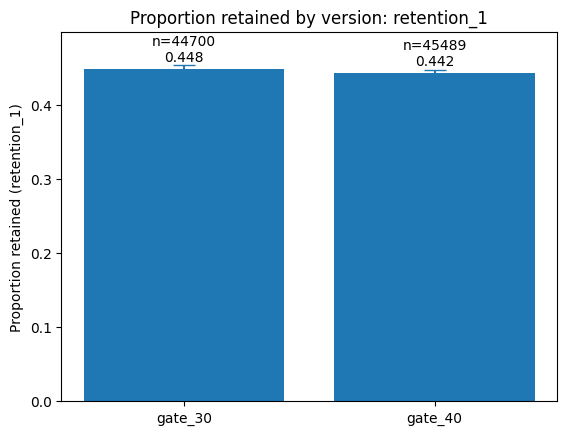

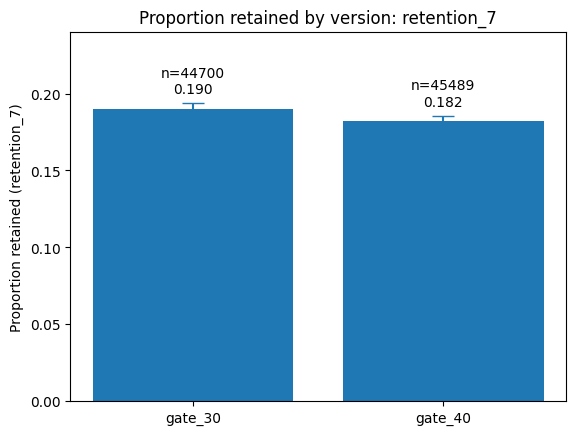

In [23]:
# Cell 8: Bar plot of proportions with 95% CI error bars (for both retention_1 and retention_7)
import matplotlib.pyplot as plt

def plot_prop_with_ci(df, outcome_col, group_col='version', groups=['gate_30','gate_40']):
    stats_list = []
    for g in groups:
        d = df[df[group_col] == g]
        n = len(d)
        x = d[outcome_col].sum()
        p = x / n
        # approximate 95% CI for single proportion (Wilson or normal approx) -> use normal approx here:
        se = np.sqrt(p*(1-p)/n)
        z = stats.norm.ppf(0.975)
        ci_low = p - z*se
        ci_hi  = p + z*se
        stats_list.append({'group': g, 'p': p, 'ci_low': ci_low, 'ci_hi': ci_hi, 'n': n})
    stats_df = pd.DataFrame(stats_list)

    fig, ax = plt.subplots()
    ax.bar(stats_df['group'], stats_df['p'])
    ax.errorbar(stats_df['group'], stats_df['p'], yerr=[stats_df['p'] - stats_df['ci_low'], stats_df['ci_hi'] - stats_df['p']],
                fmt='none', capsize=8)
    ax.set_ylim(0, min(1, stats_df['p'].max() + 0.05))
    ax.set_ylabel(f'Proportion retained ({outcome_col})')
    ax.set_title(f'Proportion retained by version: {outcome_col}')
    for i, r in stats_df.iterrows():
        ax.text(i, r['p'] + 0.01, f"n={r['n']}\n{r['p']:.3f}", ha='center')
    plt.show()

# Plot for retention_1 and retention_7
plot_prop_with_ci(df, 'retention_1')
plot_prop_with_ci(df, 'retention_7')


## Automated interpretation (based on the computed p-values)

- If **p < 0.05** for a retention metric → there is a statistically significant difference between `gate_30` and `gate_40` for that metric.
  - Check the sign of `diff_p1_p2`:
    - If `diff_p1_p2 > 0` → `gate_30` had higher retention.
    - If `diff_p1_p2 < 0` → `gate_40` had higher retention.
  - Also look at the magnitude of the difference and confidence interval to judge practical significance (is the change large enough to matter?).

- If **p >= 0.05** → no evidence of a difference at the 5% level; consider either keeping the current gate or running a larger experiment if a smaller effect size is important.

Below is a small code cell that prints a plain-language recommendation using the results we computed.


In [24]:
# Cell 10: Human-readable recommendation based on results
def recommend_from_results(res, alpha=0.05):
    out = res['outcome']
    pval = res['pval']
    diff = res['diff_p1_p2']
    lower, upper = res['ci_lower'], res['ci_upper']
    n1, n2 = res['n1'], res['n2']
    rec = f"Outcome: {out}\n"
    rec += f"Sample sizes: gate_30 n={n1}, gate_40 n={n2}\n"
    rec += f"Observed proportions: p_gate30={res['p1']:.4f}, p_gate40={res['p2']:.4f}\n"
    rec += f"Difference (p_gate30 - p_gate40) = {diff:.4f} (95% CI [{lower:.4f}, {upper:.4f}])\n"
    rec += f"z = {res['zstat']:.3f}, p = {res['pval']:.5f}\n"
    if pval < alpha:
        direction = "higher in gate_30" if diff > 0 else "higher in gate_40"
        rec += f"RESULT: Statistically significant difference (p < {alpha}). Retention is {direction}.\n"
        rec += "Recommendation: Consider adopting the better-performing gate (also evaluate product impact & business metrics).\n"
    else:
        rec += f"RESULT: No statistically significant difference at α={alpha} (p >= {alpha}).\n"
        rec += "Recommendation: No change recommended based solely on this metric. Consider power analysis if you expect a small effect.\n"
    return rec

print(recommend_from_results(res_r1))
print("----\n")
print(recommend_from_results(res_r7))


Outcome: retention_1
Sample sizes: gate_30 n=44700, gate_40 n=45489
Observed proportions: p_gate30=0.4482, p_gate40=0.4423
Difference (p_gate30 - p_gate40) = 0.0059 (95% CI [-0.0006, 0.0124])
z = 1.784, p = 0.07441
RESULT: No statistically significant difference at α=0.05 (p >= 0.05).
Recommendation: No change recommended based solely on this metric. Consider power analysis if you expect a small effect.

----

Outcome: retention_7
Sample sizes: gate_30 n=44700, gate_40 n=45489
Observed proportions: p_gate30=0.1902, p_gate40=0.1820
Difference (p_gate30 - p_gate40) = 0.0082 (95% CI [0.0031, 0.0133])
z = 3.164, p = 0.00155
RESULT: Statistically significant difference (p < 0.05). Retention is higher in gate_30.
Recommendation: Consider adopting the better-performing gate (also evaluate product impact & business metrics).



## Power / sample-size note & next steps

- If you fail to detect a statistically significant difference but care about small effects, run a **power analysis** to estimate the sample size required to detect a minimum practically important difference (e.g., +1 percentage point).
- Also check for:
  - **randomization balance**: Are other covariates balanced across versions? (e.g., device, country).
  - **segmented effects**: Maybe the gate change affects new players differently than returning players — try cohort/segment analysis.
  - **business metrics**: retention is important but weigh it vs. revenue, engagement, level completion rates, and player experience/complaints.
